### Edgar Moises Hernandez-Gonzalez
#### 29/04/20-26/05/20
#### Clasificacion binaria de imagenes motoras en EEG con CNN-2D
##### Caracteristicas = Espectrogramas STFFT (3D)
##### Concatenacion vertical
##### Resize proporcional de 264x8
##### Data Augmentation
##### 5 ejecuciones independientes

In [0]:
from google.colab import drive

In [0]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.metrics import (cohen_kappa_score, confusion_matrix,
                             roc_auc_score, roc_curve)
from scipy.signal import spectrogram
import cv2
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K

Using TensorFlow backend.


In [0]:
# para que este script funcione debe de decir 'channels_last', si dice 'channels_first' no sirve
K.image_data_format()

'channels_last'

In [0]:
x_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/Espectros-STFT-Binaria/MI-EEG-ID-A09T.csv", header=None)
x_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/Espectros-STFT-Binaria/MI-EEG-ID-A09E.csv", header=None)
y_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/Espectros-STFT-Binaria/Etiquetas-ID-A09T.csv", header=None)
y_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/Espectros-STFT-Binaria/Etiquetas-ID-A09E.csv", header=None)

In [0]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(144, 22000)
(144, 22000)
(144, 1)
(144, 1)


In [0]:
n_samples_train = len(y_train)
n_samples_test = len(y_test) #en caso de no tener el y_test se puede utilizar el x_test

print("n_samples_train:", n_samples_train)
print("n_samples_test :", n_samples_test)

n_samples_train: 144
n_samples_test : 144


In [0]:
n_classes = len(np.unique(y_test)) #esto se podria calcular asi n_clases = len(np.unique(y)), la y puede ser train o test

print("n_classes:", n_classes)

n_classes: 2


In [0]:
# las etiquetas en categorical para poder entrenar data augmentation
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

In [0]:
#unir 22 canales y resize de tamaño proporcional
def unir_espectrogramas_vertical_resize(data):
  dim = (8, 264) #ancho, alto
  fs = 250
  datos = np.zeros((144,264,8))
  temporal = np.zeros((528,4))
  for i in range(data.shape[0]): #288 muestras
    for j in range(22): #22 canales
      sig = data.iloc[i, j*1000:(j+1)*1000]
      f, t, Sxx = spectrogram(sig, fs) #espectrograma de STFFT
      temporal[j*24:(j+1)*24, :] = Sxx[8:32, :]
    resized = cv2.resize(temporal, dim, interpolation=cv2.INTER_AREA)
    datos[i] = resized
    if i % 100 == 0: #esto solo es para ver como avanza
      print(i)
  return datos

In [0]:
#llamar a unir_espectrogramas_vertical_resize(data)
x_train = unir_espectrogramas_vertical_resize(x_train)
x_test = unir_espectrogramas_vertical_resize(x_test)

0
100
0
100


In [0]:
print(x_train.shape)
print(x_test.shape)

(144, 264, 8)
(144, 264, 8)


In [0]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))
print(np.mean(x_train))
print(np.mean(x_test))

242.4780882581037
262.2188641748224
0.000989959295006045
0.0008794545979459649
3.4174904173526257
3.295674458525551


In [0]:
x = np.ceil(np.max(x_train))

In [0]:
#convertir a float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#escalar los valores en un rango de 0 a 1 (normalizar)
x_train /= x
x_test /= x

In [0]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))
print(np.mean(x_train))
print(np.mean(x_test))

0.9978522
1.07909
4.073907e-06
3.6191548e-06
0.0140637485
0.013562446


In [0]:
#convertir de 3D a 4D
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))

print(x_train.shape)
print(x_test.shape)

(144, 264, 8, 1)
(144, 264, 8, 1)


In [0]:
datagen_train = ImageDataGenerator(width_shift_range=0.25)

In [0]:
mc = ModelCheckpoint('/content/drive/My Drive/BCI-IV-2a/Modelos/Modelo_ID_STFTDA09.hdf5',
                     monitor='val_accuracy', save_best_only=True, verbose=1)

In [0]:
def CNN_2D():
  model = Sequential()
  model.add(Conv2D(16, (3,3), activation='relu', padding='same',
                   input_shape=x_train.shape[1:]))
  model.add(MaxPool2D((2,2)))
  model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
  model.add(MaxPool2D((2,2)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-4)
  model.compile(optimizer = optimizer,
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])
  return model

Iteration: 1

Epoch 00001: val_accuracy improved from -inf to 0.45139, saving model to /content/drive/My Drive/BCI-IV-2a/Modelos/Modelo_ID_STFTDA09.hdf5

Epoch 00002: val_accuracy improved from 0.45139 to 0.57639, saving model to /content/drive/My Drive/BCI-IV-2a/Modelos/Modelo_ID_STFTDA09.hdf5

Epoch 00003: val_accuracy improved from 0.57639 to 0.62500, saving model to /content/drive/My Drive/BCI-IV-2a/Modelos/Modelo_ID_STFTDA09.hdf5

Epoch 00004: val_accuracy improved from 0.62500 to 0.63889, saving model to /content/drive/My Drive/BCI-IV-2a/Modelos/Modelo_ID_STFTDA09.hdf5

Epoch 00005: val_accuracy did not improve from 0.63889

Epoch 00006: val_accuracy did not improve from 0.63889

Epoch 00007: val_accuracy did not improve from 0.63889

Epoch 00008: val_accuracy improved from 0.63889 to 0.68750, saving model to /content/drive/My Drive/BCI-IV-2a/Modelos/Modelo_ID_STFTDA09.hdf5

Epoch 00009: val_accuracy improved from 0.68750 to 0.69444, saving model to /content/drive/My Drive/BCI-IV

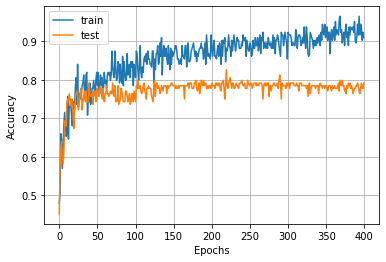

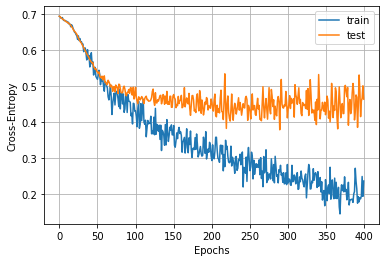

Iteration: 2

Epoch 00001: val_accuracy did not improve from 0.82639

Epoch 00002: val_accuracy did not improve from 0.82639

Epoch 00003: val_accuracy did not improve from 0.82639

Epoch 00004: val_accuracy did not improve from 0.82639

Epoch 00005: val_accuracy did not improve from 0.82639

Epoch 00006: val_accuracy did not improve from 0.82639

Epoch 00007: val_accuracy did not improve from 0.82639

Epoch 00008: val_accuracy did not improve from 0.82639

Epoch 00009: val_accuracy did not improve from 0.82639

Epoch 00010: val_accuracy did not improve from 0.82639

Epoch 00011: val_accuracy did not improve from 0.82639

Epoch 00012: val_accuracy did not improve from 0.82639

Epoch 00013: val_accuracy did not improve from 0.82639

Epoch 00014: val_accuracy did not improve from 0.82639

Epoch 00015: val_accuracy did not improve from 0.82639

Epoch 00016: val_accuracy did not improve from 0.82639

Epoch 00017: val_accuracy did not improve from 0.82639

Epoch 00018: val_accuracy did not 

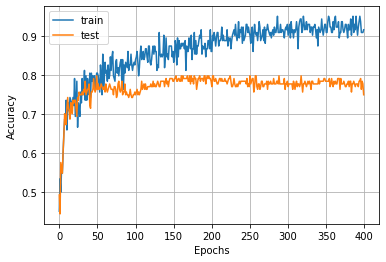

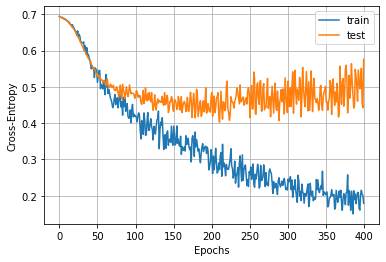

Iteration: 3

Epoch 00001: val_accuracy did not improve from 0.82639

Epoch 00002: val_accuracy did not improve from 0.82639

Epoch 00003: val_accuracy did not improve from 0.82639

Epoch 00004: val_accuracy did not improve from 0.82639

Epoch 00005: val_accuracy did not improve from 0.82639

Epoch 00006: val_accuracy did not improve from 0.82639

Epoch 00007: val_accuracy did not improve from 0.82639

Epoch 00008: val_accuracy did not improve from 0.82639

Epoch 00009: val_accuracy did not improve from 0.82639

Epoch 00010: val_accuracy did not improve from 0.82639

Epoch 00011: val_accuracy did not improve from 0.82639

Epoch 00012: val_accuracy did not improve from 0.82639

Epoch 00013: val_accuracy did not improve from 0.82639

Epoch 00014: val_accuracy did not improve from 0.82639

Epoch 00015: val_accuracy did not improve from 0.82639

Epoch 00016: val_accuracy did not improve from 0.82639

Epoch 00017: val_accuracy did not improve from 0.82639

Epoch 00018: val_accuracy did not 

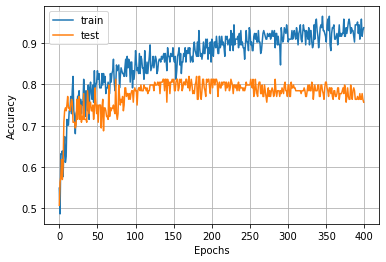

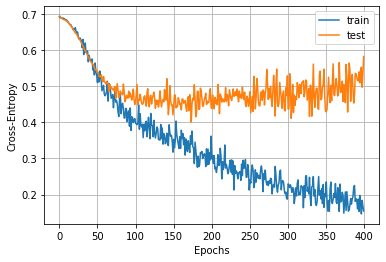

Iteration: 4

Epoch 00001: val_accuracy did not improve from 0.82639

Epoch 00002: val_accuracy did not improve from 0.82639

Epoch 00003: val_accuracy did not improve from 0.82639

Epoch 00004: val_accuracy did not improve from 0.82639

Epoch 00005: val_accuracy did not improve from 0.82639

Epoch 00006: val_accuracy did not improve from 0.82639

Epoch 00007: val_accuracy did not improve from 0.82639

Epoch 00008: val_accuracy did not improve from 0.82639

Epoch 00009: val_accuracy did not improve from 0.82639

Epoch 00010: val_accuracy did not improve from 0.82639

Epoch 00011: val_accuracy did not improve from 0.82639

Epoch 00012: val_accuracy did not improve from 0.82639

Epoch 00013: val_accuracy did not improve from 0.82639

Epoch 00014: val_accuracy did not improve from 0.82639

Epoch 00015: val_accuracy did not improve from 0.82639

Epoch 00016: val_accuracy did not improve from 0.82639

Epoch 00017: val_accuracy did not improve from 0.82639

Epoch 00018: val_accuracy did not 

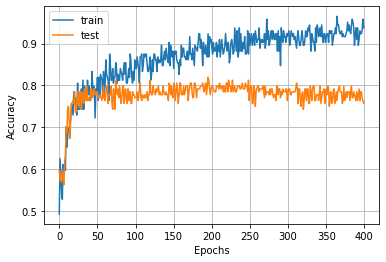

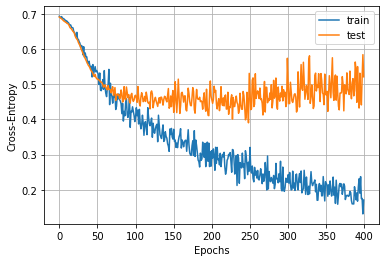

Iteration: 5

Epoch 00001: val_accuracy did not improve from 0.82639

Epoch 00002: val_accuracy did not improve from 0.82639

Epoch 00003: val_accuracy did not improve from 0.82639

Epoch 00004: val_accuracy did not improve from 0.82639

Epoch 00005: val_accuracy did not improve from 0.82639

Epoch 00006: val_accuracy did not improve from 0.82639

Epoch 00007: val_accuracy did not improve from 0.82639

Epoch 00008: val_accuracy did not improve from 0.82639

Epoch 00009: val_accuracy did not improve from 0.82639

Epoch 00010: val_accuracy did not improve from 0.82639

Epoch 00011: val_accuracy did not improve from 0.82639

Epoch 00012: val_accuracy did not improve from 0.82639

Epoch 00013: val_accuracy did not improve from 0.82639

Epoch 00014: val_accuracy did not improve from 0.82639

Epoch 00015: val_accuracy did not improve from 0.82639

Epoch 00016: val_accuracy did not improve from 0.82639

Epoch 00017: val_accuracy did not improve from 0.82639

Epoch 00018: val_accuracy did not 

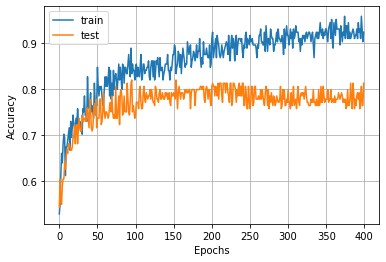

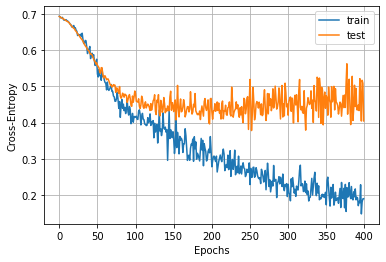


Resultados:
loss: [0.46388176414701676, 0.5759305755297343, 0.5821555587980483, 0.520790716012319, 0.40472375684314305]
accuracy: [0.7916666865348816, 0.75, 0.7569444179534912, 0.7569444179534912, 0.8125]
kappa: [0.5833333333333333, 0.5, 0.5138888888888888, 0.5138888888888888, 0.625]
AUC: [0.9286265432098765, 0.9189814814814814, 0.9155092592592593, 0.9120370370370371, 0.9255401234567902]
Tiempo: 210.78066277503967


In [0]:
inicio = time.time()
array_loss = []
array_acc = []
array_kappa = []
array_auc = []
for i in range(5):
  print("Iteration:", i+1)
    
  model = CNN_2D()

  history = model.fit_generator(datagen_train.flow(x_train, y_train_categorical, batch_size=18),
                                steps_per_epoch=np.ceil(n_samples_train/18),
                                epochs=400,
                                validation_data=(x_test, y_test_categorical),
                                verbose=0, callbacks=[mc])

  test_loss, test_acc = model.evaluate(x_test, y_test_categorical, verbose=0)
  array_loss.append(test_loss)
  print("loss: ", test_loss)
  array_acc.append(test_acc)
  print("accuracy: ", test_acc)
    
  probabilidades = model.predict(x_test)
  y_pred = np.argmax(probabilidades, 1) #1=fila
    
  kappa = cohen_kappa_score(y_test, y_pred)
  array_kappa.append(kappa)
  print("kappa: ", kappa)
    
  matriz_confusion = confusion_matrix(y_test, y_pred)
  print("confusion matrix:\n", matriz_confusion)

  probabilidades = probabilidades[:, 1]
  auc = roc_auc_score(y_test, probabilidades)
  #fpr, tpr, thresholds = roc_curve(y_test, probabilidades)
  array_auc.append(auc)

  print("AUC", auc)
  #plt.plot(fpr, tpr)
  #plt.grid()
  #plt.xlabel('False Positive Rate')
  #plt.ylabel('True Positive Rate')
  #plt.show()

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'test'])
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy')
  plt.legend(['train', 'test'])
  plt.show()
print()
print("Resultados:")
print("loss:", array_loss)
print("accuracy:", array_acc)
print("kappa:", array_kappa)
print("AUC:", array_auc)
fin = time.time()
print("Tiempo:", fin - inicio)

In [0]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 264, 8, 16)        160       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 132, 4, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 132, 4, 16)        2320      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 66, 2, 16)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 2112)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               270464    
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)              

In [0]:
print("Mean Accuracy: %.4f" % np.mean(array_acc))
print("std: (+/- %.4f)" % np.std(array_acc))
print("Mean Kappa: %.4f" % np.mean(array_kappa))
print("std: (+/- %.4f)" % np.std(array_kappa))
print("Mean AUC: %.4f" % np.mean(array_auc))
print("std: (+/- %.4f)" % np.std(array_auc))
print("Max Accuracy: %.4f" % np.max(array_acc))
print("Max Kappa: %.4f" % np.max(array_kappa))
print("Max AUC: %.4f" % np.max(array_auc))

Mean Accuracy: 0.7736
std: (+/- 0.0243)
Mean Kappa: 0.5472
std: (+/- 0.0486)
Mean AUC: 0.9201
std: (+/- 0.0062)
Max Accuracy: 0.8125
Max Kappa: 0.6250
Max AUC: 0.9286


In [0]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue May 26 03:39:34 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    24W /  75W |    977MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  